In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax

import matplotlib.pyplot as plt

In [9]:
from models.base_model import BaseModel, NormalDistPredictor, AffinedTanh
from models.base_q_estimator import BaseQEstimator

from agents.SAC import SAC

from samplers.sampler import Sampler

from off_policy_trainer import build_trainer

from structs import Buffer

from utils.callback import tqdm_callback

In [5]:
action_limits = (-2, 2)

actor_lr = 1e-2
critic_lr = 1e-2

discount = 0.99

num_envs = 8

batch_size = 128
polyak_coef = 0.95
entropy_alpha = 0.2

iters = 1000

max_episode_steps = 400

steps_per_update = 8

buffer_size_before_training = 1000

buffer_size = int(1e4)

env_name = "Pendulum-v1"

In [6]:
env, env_params = gymnax.make(env_name)

obs_size = env.observation_space(env_params).shape[0]
action_size = env.action_space(env_params).shape[0]

In [11]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(64)
    
    dummy = jnp.ones([1, obs_size])
    action_dummy = jnp.ones([1, action_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), NormalDistPredictor(output_size = action_size, limits = action_limits)])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseQEstimator(hidden_size = 128, num_layers = 2), nn.Dense(features = 1)])

    critic_init_key_1, critic_init_key_2 = jax.random.split(critic_init_key, 2)
    critic_params_1 = critic_model.init(critic_init_key_1, dummy, action_dummy)['params']
    critic_tx_1 = optax.adam(critic_lr)
    critic_1 = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params_1,
                              tx=critic_tx_1,
                              )

    critic_params_2 = critic_model.init(critic_init_key_2, dummy, action_dummy)['params']
    critic_tx_2 = optax.adam(critic_lr)
    critic_2 = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params_2,
                              tx=critic_tx_2,
                              )
    
    agent = SAC(discount, polyak_coef, entropy_alpha, action_limits)
    
    buffer = Buffer(
        jnp.zeros((num_envs, buffer_size, obs_size)),
        jnp.zeros((num_envs, buffer_size, 1)),
        jnp.zeros((num_envs, buffer_size, 1)),
        jnp.zeros((num_envs, buffer_size, 1)),
        jnp.zeros((buffer_size,)),
        0
    )

    sampler = Sampler(batch_size)
    
    logger = jnp.zeros((iters, 1))

    fori_body = build_trainer(agent, sampler, env, env_params, num_envs, obs_size, action_size, max_episode_steps, buffer_size_before_training, steps_per_update, tqdm_callback(iters))
    
    carry = (actor, (critic_1, critic_2), None, (critic_1.params, critic_2.params), buffer, logger, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

100%|██████████| 1000/1000 [02:29<00:00,  7.57it/s, Reward=-195.52473]

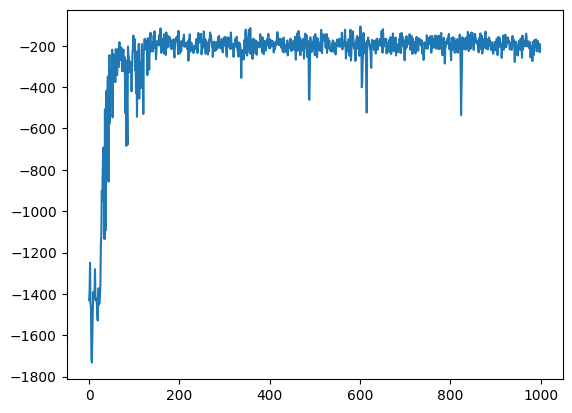

In [12]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(carry[-2][:])
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:252: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'jaxlib.xla_extension.ArrayImpl'>
  logger.warn(
MovieWriter imagemagick unavailable; using Pillow instead.


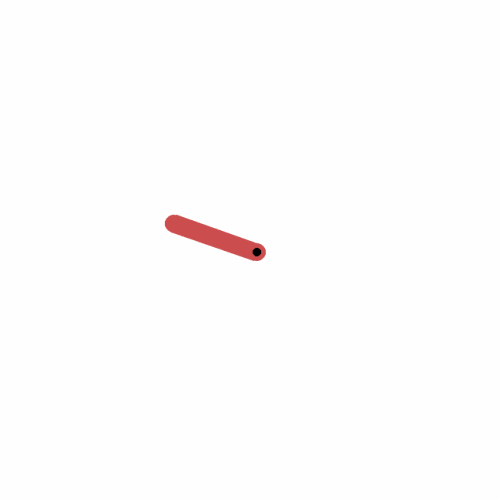

In [14]:
from utils.render import save_frames_as_gif

from IPython.display import Image
from tqdm.notebook import tqdm
import gym

actor = carry[0]

gym_env = gym.make(env_name, render_mode="rgb_array")

obs, _ = gym_env.reset()
frames = []
for t in tqdm(range(500)):
    frames.append(gym_env.render())
    action = agent.suggest_action(jnp.expand_dims(obs, 0), actor)[0]
    obs, _, done, _, _ = gym_env.step(action)
    if done:
        break
        
gym_env.close()

save_frames_as_gif(frames, filename = "tmp.gif")

Image(open('tmp.gif','rb').read())